## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

In [10]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from time import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

### Extract Features
The feature contains HOG feature, color histogram, and binned color feature. As hinted in the lecture, I converted the  image into different color space including RGB (original), HSV, HSL, YCrCb and tried all channels and individual channels for each conversion. Using Hue of HSV perform well as expected since it can sort differentiate the vehicles from background. Using this feature alone can present an accuracy of 0.93. Using all channels of LUV eventually stands out in the training accuracy. Color histogram and bin features both help enhancing the accuracy. The combination I picked can eventaully hit an accuracy of 0.989. Using more bins will eventually help to bring it above 0.99. However, more channels or bins will dramatically slow down the processing for each image. As the result the time to process one video might be extended from 1h to 3h. Training time will be longer with higher dimension of feature.

(768,)
(96,)
(2048,)
(3,)


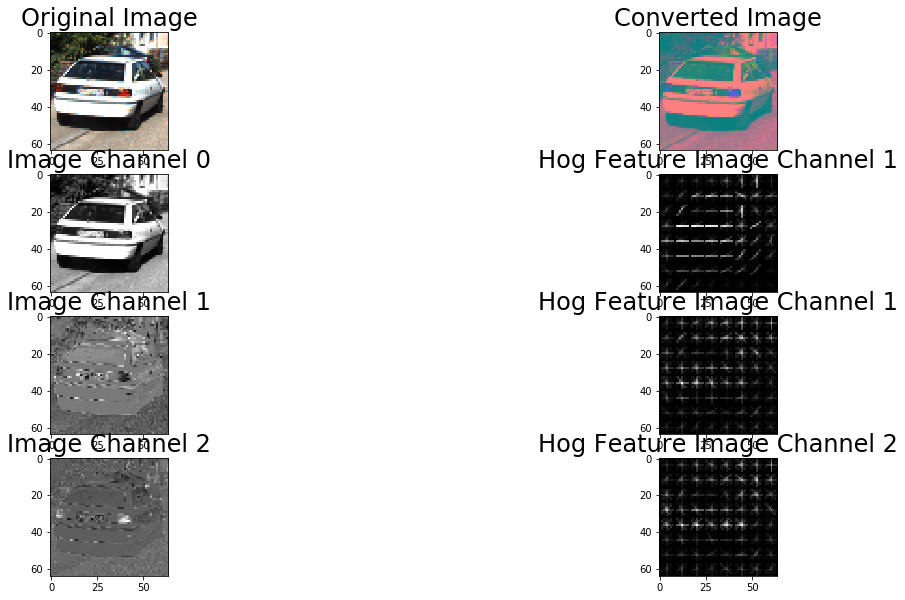

In [67]:
def extract_features(img, quiet = True):
    
    result = []
    
    # Compute binned color features
    bin_feature = cv2.resize(img, (16, 16)).ravel()
    result.append(bin_feature)
    
    # Compute color histogram
    color_channels = []
    for channel in range(img.shape[2]):
        color_channels.append(np.histogram(img[:,:,channel], bins=32, range=(0, 256))[0])
    color_hist = np.hstack(color_channels)
    result.append(color_hist)
    
    # Compute HOG
    pix_per_cell = 8
    cell_per_block = 1
    orient = 8
    
    # Convert to certain color space (from RGB) for extracting the HOG features
    
    converted = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    hog_feature = []
    hog_images = []
    
    for channel in range(img.shape[2]):
        feature, hog_image = hog(converted[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        hog_feature.append(np.ravel(feature))
        hog_images.append(hog_image)
    #feature, hog_image = hog(converted[:,:], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    hog_feature.append(np.ravel(feature))
    hog_images.append(hog_image)
    
    hog_feature = np.ravel(hog_feature)
    result.append(hog_feature)
    
    if(quiet == False):
        print(np.shape(bin_feature))
        print(np.shape(color_hist))
        print(np.shape(hog_feature))
        print(np.shape(result))
        # Visualize hog feature image
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,10))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=24)
        ax2.imshow(converted)
        ax2.set_title('Converted Image', fontsize=24)
        
        ax3.imshow(converted[:,:,0], cmap='gray')
        ax3.set_title('Image Channel 0', fontsize=24)
        ax4.imshow(hog_images[0], cmap='gray')
        ax4.set_title('Hog Feature Image Channel 1', fontsize=24)
        
        ax5.imshow(converted[:,:,1], cmap='gray')
        ax5.set_title('Image Channel 1', fontsize=24)
        ax6.imshow(hog_images[1], cmap='gray')
        ax6.set_title('Hog Feature Image Channel 1', fontsize=24)
        
        ax7.imshow(converted[:,:,2], cmap='gray')
        ax7.set_title('Image Channel 2', fontsize=24)
        ax8.imshow(hog_images[2], cmap='gray')
        ax8.set_title('Hog Feature Image Channel 2', fontsize=24)
    result = np.concatenate(result)
    return result

img = cv2.imread('./test_images/image_kitti.png')
feature = extract_features(img,  quiet = False)

## Load Training Data and Persistate Extracted Features
Read all data from the 'vehicles' and 'non-vehicles' folder provided. It takes more than 5m to extract features from 8k+ training images in each folder. So I read labeled data and store them in local pickle file.

In [68]:
vehicle_features = []
non_vehicle_features = []

t1 = time()
for img_path in glob.glob('../vehicles/*/*.png'):
    img = cv2.imread(img_path)
    vehicle_features.append(extract_features(img))

print(len(vehicle_features))
print("Loading labeled vehicle time: ", round(time()-t1, 3), "s")

t1 = time()
for img_path in glob.glob('../non-vehicles/*/*.png'):
    img = cv2.imread(img_path)
    non_vehicle_features.append(extract_features(img))
        
print(len(non_vehicle_features))
print("Loading labeled non-vehicle time: ", round(time()-t1, 3), "s")

8792
Loading labeled vehicle time:  366.238 s
8968
Loading labeled non-vehicle time:  349.59 s


In [72]:
# Save the extracted features to local
pickle_file = {}
pickle_file["vehicle_features"] = vehicle_features
pickle_file["non_vehicle_features"] = non_vehicle_features
pickle.dump(pickle_file, open( "./gray_features.p", "wb" ))

## Train the Classifier
Load the features stored in local pickle. The features are normalized and split into training and testing part. The training part of the features are feed into a SVM classifier. I used the LinearSVC classifier given in the lecture script. Seems the accuracy is sufficient for vehicle detection. The training speed is impressive. 80% of 17K is still over 13K. But the training only took 1.6s.

In [73]:
file = open("./gray_features.p",'rb')
features = pickle.load(file)
vehicle_features = features["vehicle_features"]
print(len(vehicle_features))
non_vehicle_features = features["non_vehicle_features"]
print(len(non_vehicle_features))

8792
8968


In [74]:
print(np.shape(vehicle_features[0]))
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rs = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rs)

svc = LinearSVC(loss='hinge') # Use a linear SVC 
t1 = time()
svc.fit(X_train, y_train) # Train the classifier
print("Training time: ", round(time()-t1, 3), "s")
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

(2912,)
Training time:  1.623 s
Test Accuracy of SVC =  0.9924


## Remove Image Distortion
Since we used the same video from previous project, we need to perform remove image distortion from each frame. The pickle file containing the camera matrix and distortion coefficients from previous calibration is reused here.

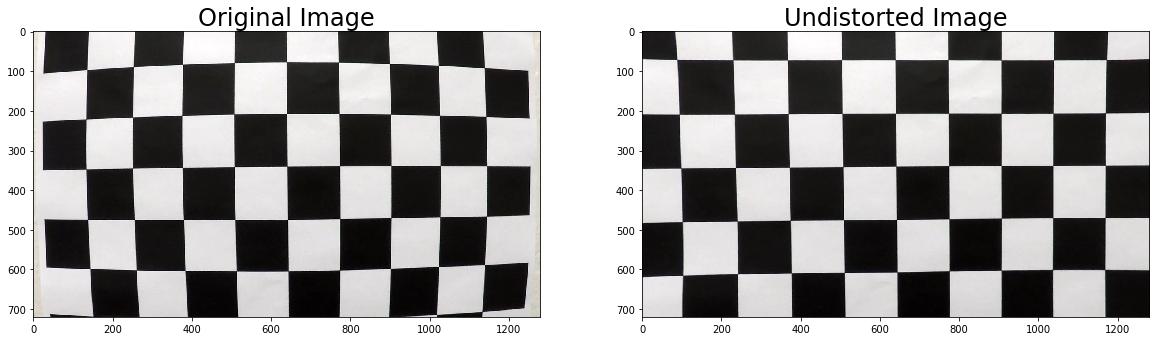

In [75]:
# load dist pickle that contains the camera matrix and distortion coefficients
def read_mtx_dist():
    file = open("./wide_dist_pickle.p",'rb')
    dist_pickle = pickle.load(file)
    file.close()
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

def remove_distortion(img, mtx, dist, quiet = True):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('../camera_cal/test_undist.jpg',dst)
    if(quiet == False):
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=24)
        ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=24)
    return dst


mtx, dist = read_mtx_dist()

# Test undistortion on an image
test_cali_img = cv2.imread('./calibration1.jpg')
undistort = remove_distortion(test_cali_img, mtx, dist, False)

## Sliding Window Implementation

Here we define a sliding window function `slide_window` to generate a list of boxes with predefined parameters and a `draw_boxes` to draw the list of boxes on an image. I used 3 types of window with different sizes corresponding to the distance to the observing car. Note there are overlapping area since it's impossible to tell the size of the vehicles simply based on their location on the image. Larger 'xy_overlap' tends to give much better result since we are doing the window scan more frequently and is more likely to detect target and form the heat spot above threshold. However, this also requires more computing power and time.

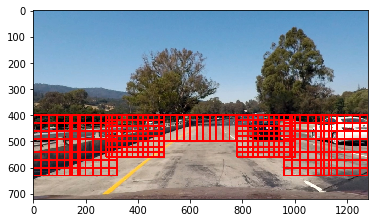

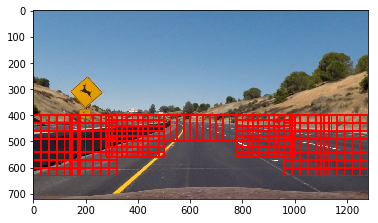

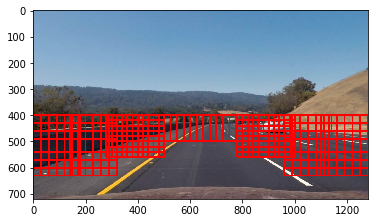

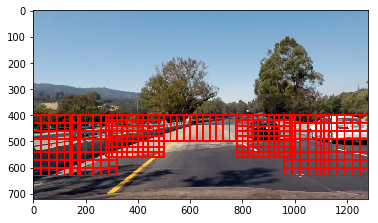

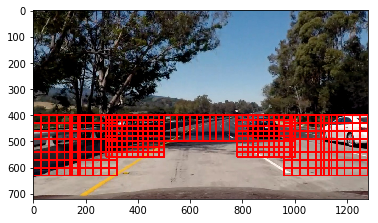

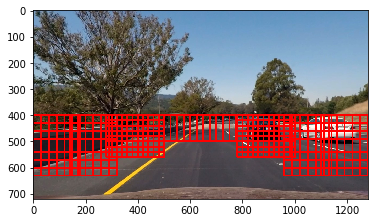

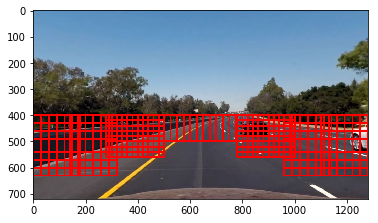

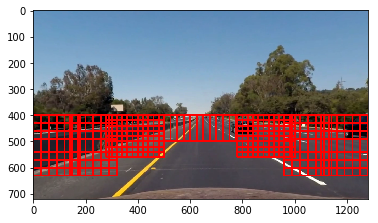

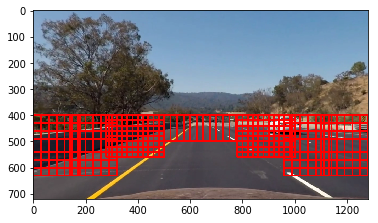

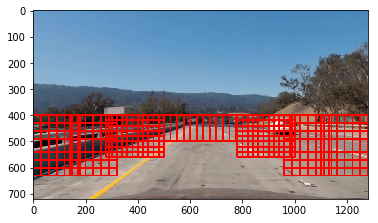

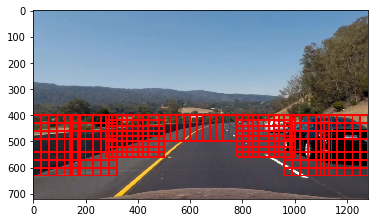

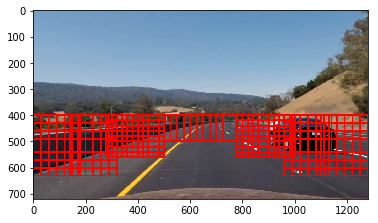

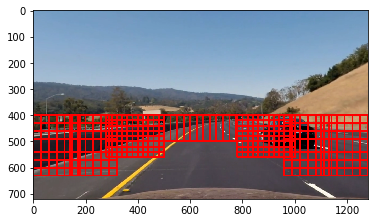

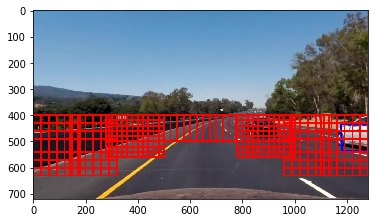

In [144]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

img = cv2.imread('./test_images/test1.jpg')
windows1 = slide_window(img, x_start_stop=[0, 320], y_start_stop=[400, 640], 
                    xy_window=(140, 140), xy_overlap=(0.78, 0.78))

windows2 = slide_window(img, x_start_stop=[280, 500], y_start_stop=[400, 560], 
                    xy_window=(80, 80), xy_overlap=(0.75, 0.75))

windows3 = slide_window(img, x_start_stop=[500, 780], y_start_stop=[400, 500], 
                    xy_window=(100, 100), xy_overlap=(0.75, 0.75))

windows4 = slide_window(img, x_start_stop=[780, 1000], y_start_stop=[400, 560], 
                    xy_window=(80, 80), xy_overlap=(0.75, 0.75))

windows5 = slide_window(img, x_start_stop=[960, 1280], y_start_stop=[400, 640], 
                    xy_window=(140, 140), xy_overlap=(0.78, 0.78))
windows = windows1 + windows2 + windows3 + windows4 + windows5


for img_path in glob.glob('./test_images/test*.*'):
    img = cv2.imread(img_path)
    img = remove_distortion(img, mtx, dist, True)
    window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)
    plt.figure()
    plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))

Each window defined by slide_windows() will be filtered by the trained predictor and classified as 'vehicle' or 'non-vehicle'. Note to save final video processing time, I removed the two windows on the left side. I tested it on these area and there are minimum false alarms for the given video.

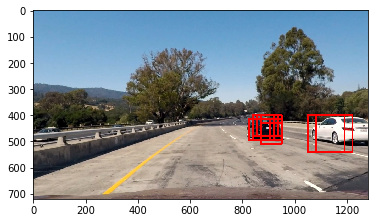

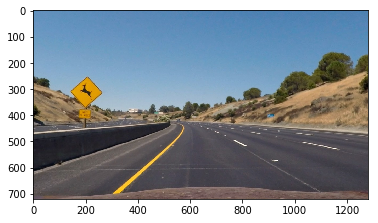

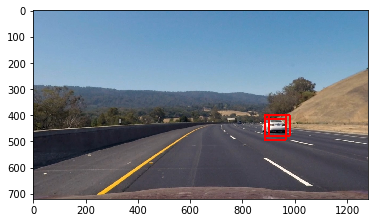

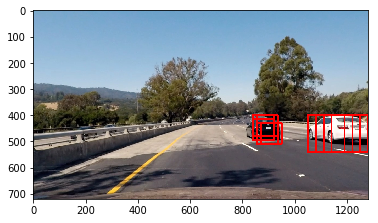

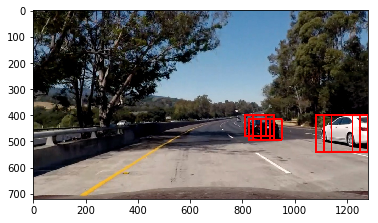

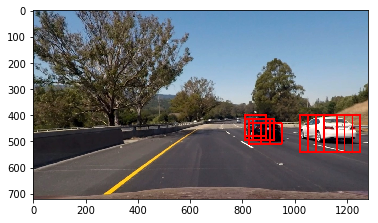

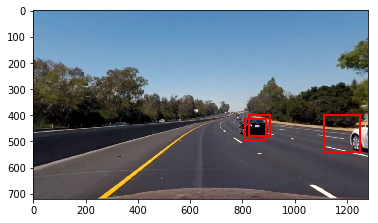

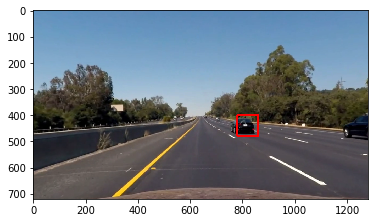

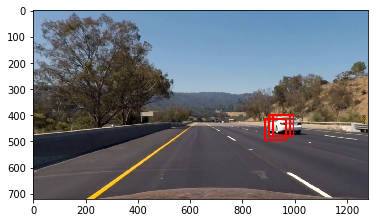

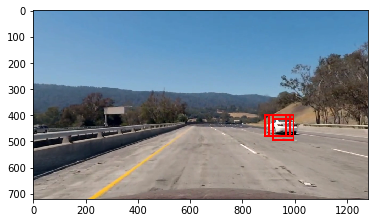

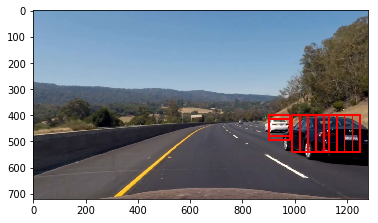

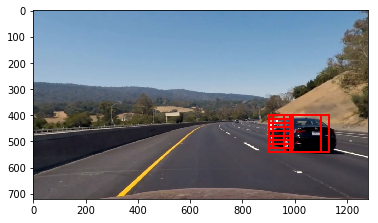

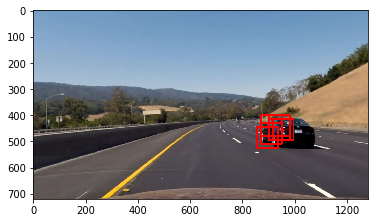

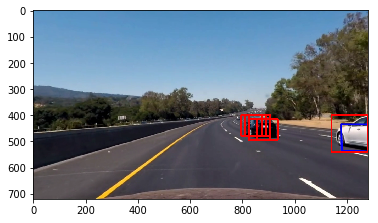

In [146]:
windows1 = slide_window(img, x_start_stop=[600, 800], y_start_stop=[400, 500], 
                    xy_window=(100, 100), xy_overlap=(0.8, 0.8))

windows2 = slide_window(img, x_start_stop=[780, 1000], y_start_stop=[400, 560], 
                    xy_window=(80, 80), xy_overlap=(0.8, 0.8))

windows3 = slide_window(img, x_start_stop=[960, 1280], y_start_stop=[400, 640], 
                    xy_window=(140, 140), xy_overlap=(0.78, 0.78))
windows = windows1 + windows2 + windows3

def search_windows(img, windows, clf, scaler):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
                

for img_path in glob.glob('./test_images/test*.*'):
    img = cv2.imread(img_path)
    img = remove_distortion(img, mtx, dist, True)
    hot_windows = search_windows(img, windows, svc, X_scaler)                       
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    plt.figure()
    plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))

Note on the result above the windows are overlapping and many adjacent windows might all detect the same vehicle. We need to find a way to form a unified bounding box for each detected target. The heat map method is introduced to accumulate the count for the overlapping area and only those above a given threshold will be considered valid prediction. I set the threshold to 2. This effectively eliminate majority of false alarm and effectively maintained real targets. 

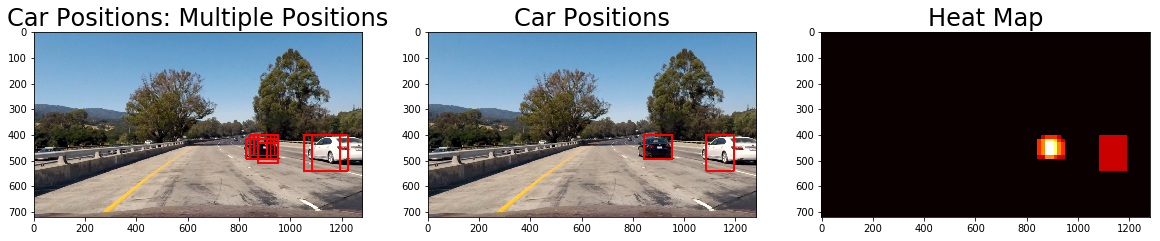

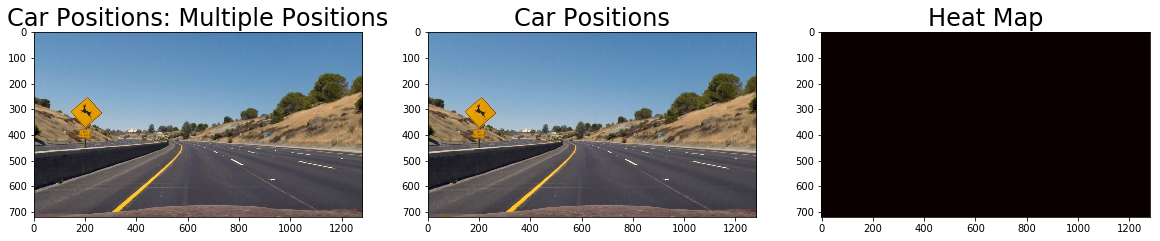

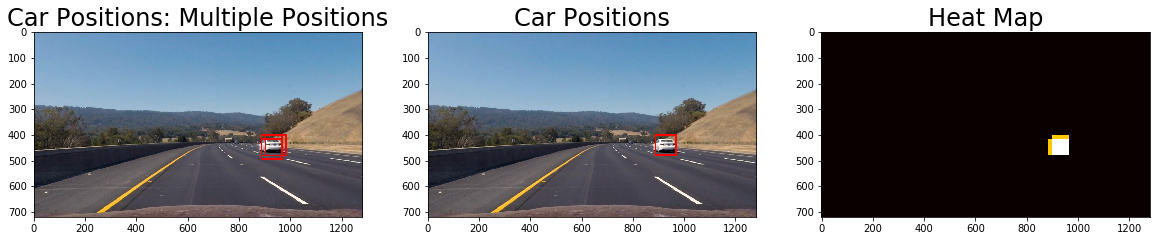

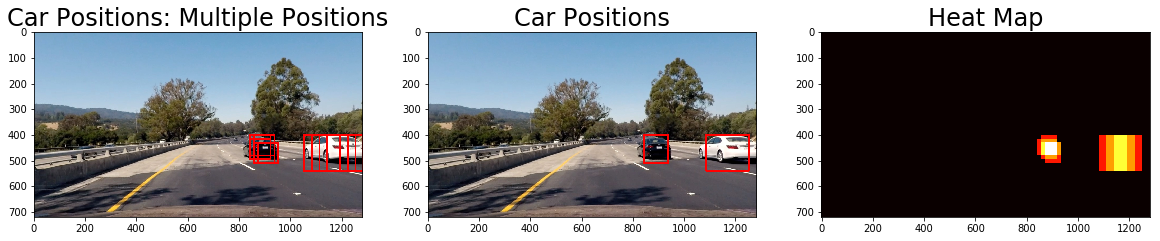

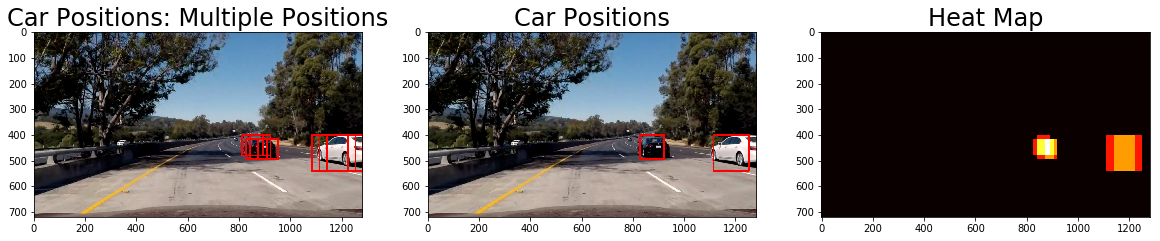

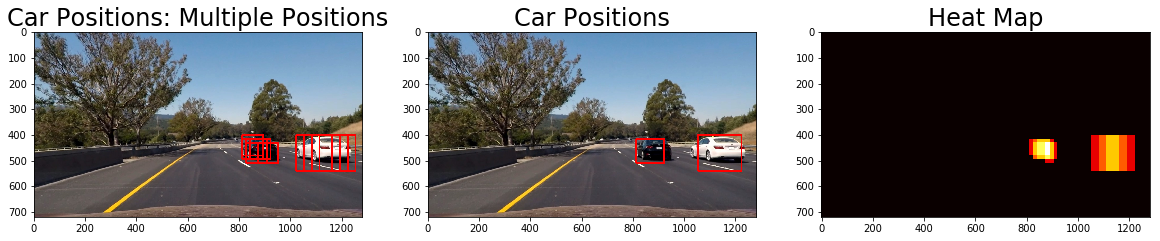

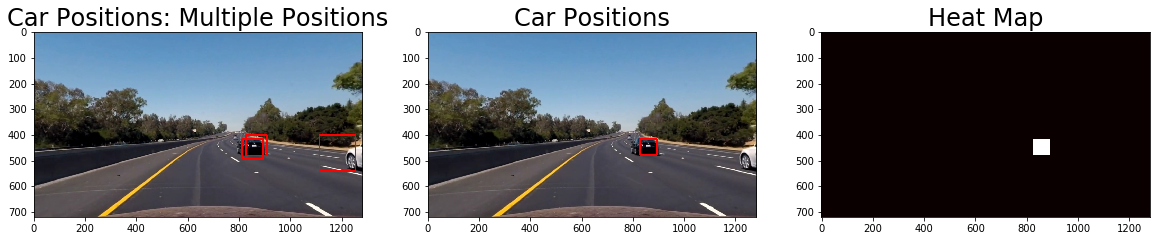

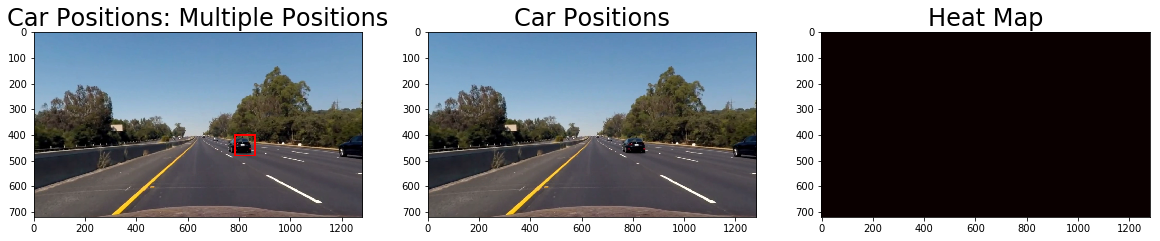

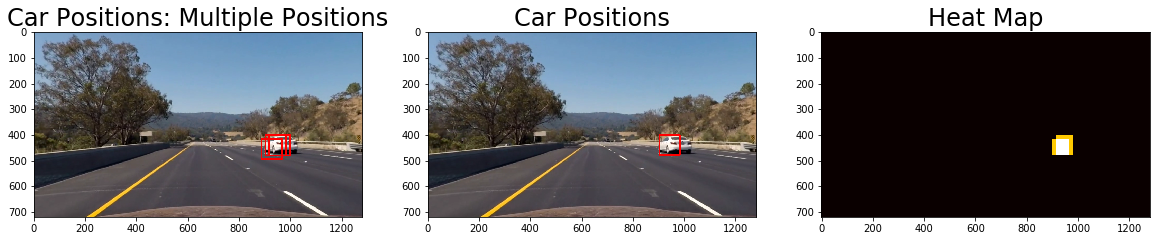

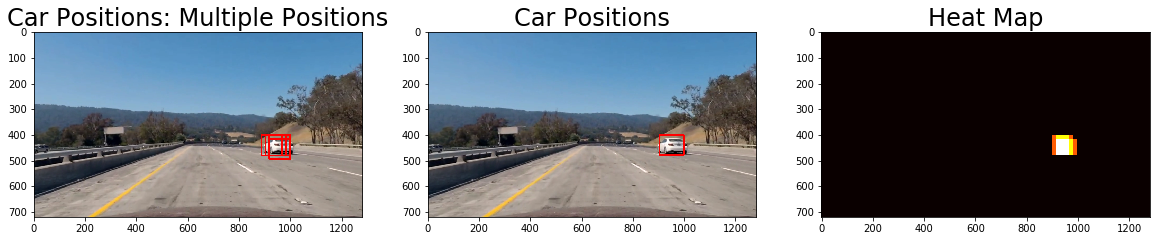

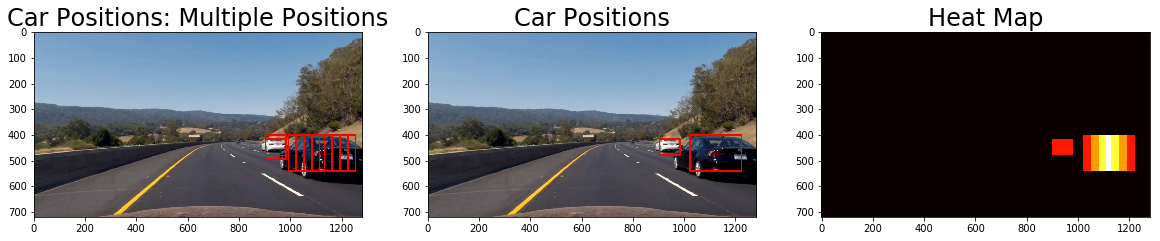

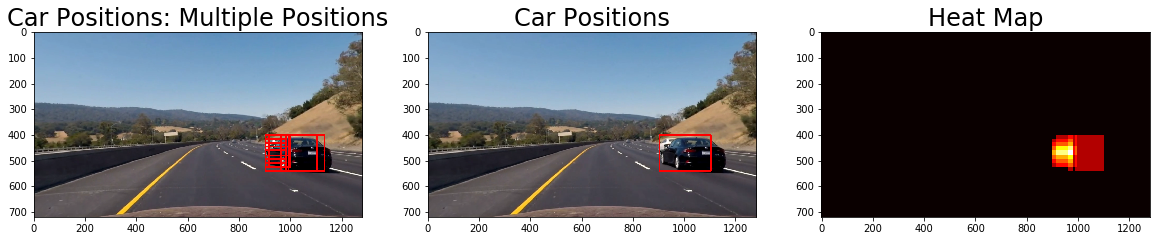

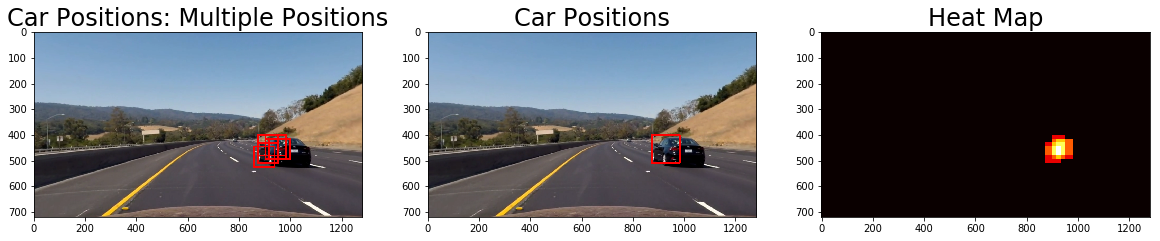

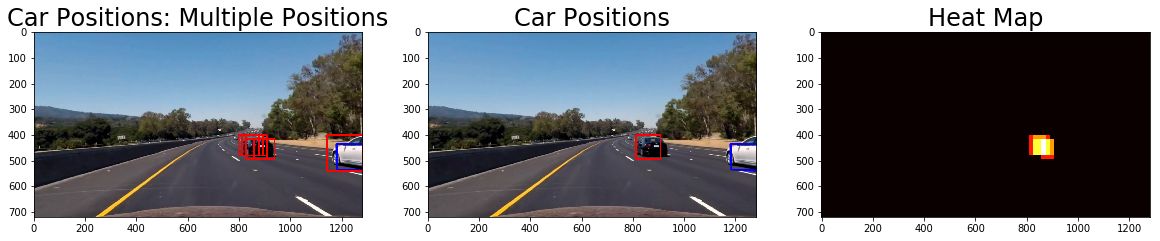

In [147]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


for img_path in glob.glob('./test_images/test*.*'):
    img = cv2.imread(img_path)
    img = remove_distortion(img, mtx, dist, True)
    hot_windows = search_windows(img, windows, svc, X_scaler)                       
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    plt.figure()
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Car Positions: Multiple Positions', fontsize=24)
    ax2.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Car Positions', fontsize=24)
    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title('Heat Map', fontsize=24)

## Pipeline
The final pipeline contains the image distortion, window search, heatmap thresholding and labeling. Although the heatmap looks valid in the previoius section, in individual frames many false positive appeared in the processed video. The correct tracking boxes also look flaky. A straight-forward way to improve is that using a deque to store history heat map boxes. Only boxes recent 10 frames would be stored. Only when accumulated heat values exceed a threashold will this position be considered a true detection. This method will greatly mitigate false positives and also renders much smoother tracking boxes.

In [148]:
from collections import deque

n_frames = 10
heatmaps = deque(maxlen = n_frames)

def pipeline(img):
    img = remove_distortion(img, mtx, dist, True)
    hot_windows = search_windows(img, windows, svc, X_scaler)      
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    print(np.shape(heat))

    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,1)
    #print(heat)
    
    # Visualize the heatmap when displaying
    heatmaps.append(heat)
    print(np.shape(heatmaps))
    
    threshold = 11
    combined = sum(heatmaps)
    print(np.shape(combined))
    combined = apply_threshold(combined, threshold)
    print(np.shape(combined))
    
    combined = np.clip(combined, 0, 255)
    labels = label(combined)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

## Video Processing
Call pipeline function for each frame of the video and recompose a new video.

In [153]:
from moviepy.editor import VideoFileClip
output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(5,50)
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)
[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


  0%|          | 1/1126 [00:03<1:06:30,  3.55s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  0%|          | 2/1126 [00:07<1:06:03,  3.53s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  0%|          | 3/1126 [00:10<1:05:46,  3.51s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  0%|          | 4/1126 [00:14<1:06:32,  3.56s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  0%|          | 5/1126 [00:17<1:05:55,  3.53s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 6/1126 [00:20<1:04:25,  3.45s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 7/1126 [00:24<1:03:00,  3.38s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 8/1126 [00:27<1:02:01,  3.33s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 9/1126 [00:30<1:01:27,  3.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 10/1126 [00:33<1:00:55,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 11/1126 [00:36<1:00:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 12/1126 [00:40<1:00:18,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 13/1126 [00:43<1:00:08,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|          | 14/1126 [00:46<1:00:06,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|▏         | 15/1126 [00:49<1:00:08,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  1%|▏         | 16/1126 [00:53<1:00:05,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 17/1126 [00:56<1:00:16,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 18/1126 [00:59<1:01:07,  3.31s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 19/1126 [01:03<1:01:15,  3.32s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 20/1126 [01:06<1:00:44,  3.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 21/1126 [01:09<1:00:17,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 22/1126 [01:12<1:00:02,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 23/1126 [01:16<59:49,  3.25s/it]  

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 24/1126 [01:19<59:41,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 25/1126 [01:22<59:34,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 26/1126 [01:25<59:24,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 27/1126 [01:29<59:17,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  2%|▏         | 28/1126 [01:32<59:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 29/1126 [01:35<59:14,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 30/1126 [01:38<59:10,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 31/1126 [01:42<59:03,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 32/1126 [01:45<59:04,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 33/1126 [01:48<58:56,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 34/1126 [01:51<58:45,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 35/1126 [01:54<58:41,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 36/1126 [01:58<58:51,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 37/1126 [02:01<58:44,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 38/1126 [02:04<58:38,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  3%|▎         | 39/1126 [02:07<58:22,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▎         | 40/1126 [02:11<58:20,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▎         | 41/1126 [02:14<58:24,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▎         | 42/1126 [02:17<58:22,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 43/1126 [02:20<58:16,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 44/1126 [02:24<58:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 45/1126 [02:27<58:19,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 46/1126 [02:30<58:13,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 47/1126 [02:33<58:13,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 48/1126 [02:37<58:07,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 49/1126 [02:40<58:07,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  4%|▍         | 50/1126 [02:43<58:02,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▍         | 51/1126 [02:46<58:11,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▍         | 52/1126 [02:50<58:22,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▍         | 53/1126 [02:53<58:07,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▍         | 54/1126 [02:56<58:01,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▍         | 55/1126 [02:59<57:57,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▍         | 56/1126 [03:03<57:49,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▌         | 57/1126 [03:06<57:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▌         | 58/1126 [03:09<57:48,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▌         | 59/1126 [03:12<57:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▌         | 60/1126 [03:16<57:37,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  5%|▌         | 61/1126 [03:19<57:32,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 62/1126 [03:22<57:30,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 63/1126 [03:25<57:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 64/1126 [03:28<57:15,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 65/1126 [03:32<57:14,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 66/1126 [03:35<57:06,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 67/1126 [03:38<56:56,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 68/1126 [03:41<57:03,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 69/1126 [03:45<57:01,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▌         | 70/1126 [03:48<56:53,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▋         | 71/1126 [03:51<56:47,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▋         | 72/1126 [03:54<56:45,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  6%|▋         | 73/1126 [03:58<56:37,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 74/1126 [04:01<56:41,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 75/1126 [04:04<56:44,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 76/1126 [04:07<56:34,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 77/1126 [04:10<56:33,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 78/1126 [04:14<56:31,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 79/1126 [04:17<56:28,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 80/1126 [04:20<56:32,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 81/1126 [04:23<56:25,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 82/1126 [04:27<56:22,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 83/1126 [04:30<56:35,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 84/1126 [04:33<56:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 85/1126 [04:36<56:17,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 86/1126 [04:40<56:15,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 87/1126 [04:43<56:05,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 88/1126 [04:46<56:03,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 89/1126 [04:49<56:08,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 90/1126 [04:53<56:04,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 91/1126 [04:56<55:56,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 92/1126 [04:59<55:50,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 93/1126 [05:02<55:46,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 94/1126 [05:06<55:41,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  8%|▊         | 95/1126 [05:09<55:39,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▊         | 96/1126 [05:12<55:39,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▊         | 97/1126 [05:15<55:33,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▊         | 98/1126 [05:19<55:31,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 99/1126 [05:22<55:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 100/1126 [05:25<55:43,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 101/1126 [05:28<55:34,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 102/1126 [05:32<55:25,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 103/1126 [05:35<55:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 104/1126 [05:38<55:15,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 105/1126 [05:41<55:09,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


  9%|▉         | 106/1126 [05:45<55:10,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|▉         | 107/1126 [05:48<55:01,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|▉         | 108/1126 [05:51<54:59,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|▉         | 109/1126 [05:54<54:53,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|▉         | 110/1126 [05:58<54:54,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|▉         | 111/1126 [06:01<54:50,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|▉         | 112/1126 [06:04<54:54,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|█         | 113/1126 [06:07<54:52,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|█         | 114/1126 [06:11<54:51,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|█         | 115/1126 [06:14<54:51,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|█         | 116/1126 [06:17<54:46,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|█         | 117/1126 [06:20<54:47,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 10%|█         | 118/1126 [06:24<54:38,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 119/1126 [06:27<54:34,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 120/1126 [06:30<54:36,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 121/1126 [06:33<54:38,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 122/1126 [06:37<54:29,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 123/1126 [06:40<54:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 124/1126 [06:43<54:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 125/1126 [06:46<54:16,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 126/1126 [06:50<54:22,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█▏        | 127/1126 [06:53<54:17,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█▏        | 128/1126 [06:56<54:24,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 11%|█▏        | 129/1126 [06:59<54:12,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 130/1126 [07:03<54:03,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 131/1126 [07:06<53:54,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 132/1126 [07:09<53:57,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 133/1126 [07:12<53:56,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 134/1126 [07:16<53:47,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 135/1126 [07:19<53:45,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 136/1126 [07:22<53:39,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 137/1126 [07:25<53:34,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 138/1126 [07:29<53:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 139/1126 [07:32<53:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 140/1126 [07:35<53:25,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 141/1126 [07:38<53:19,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 142/1126 [07:42<53:15,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 143/1126 [07:45<53:05,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 144/1126 [07:48<53:01,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 145/1126 [07:51<53:05,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 146/1126 [07:55<53:04,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 147/1126 [07:58<52:52,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 148/1126 [08:01<52:50,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 149/1126 [08:04<52:47,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 150/1126 [08:08<52:54,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 151/1126 [08:11<52:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 13%|█▎        | 152/1126 [08:14<52:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▎        | 153/1126 [08:17<52:41,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▎        | 154/1126 [08:21<52:53,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 155/1126 [08:24<52:52,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 156/1126 [08:27<52:53,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 157/1126 [08:30<52:39,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 158/1126 [08:34<52:25,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 159/1126 [08:37<52:23,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 160/1126 [08:40<52:12,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 161/1126 [08:43<52:01,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 162/1126 [08:47<52:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 163/1126 [08:50<52:18,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▍        | 164/1126 [08:53<52:17,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▍        | 165/1126 [08:56<52:04,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▍        | 166/1126 [09:00<52:00,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▍        | 167/1126 [09:03<51:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▍        | 168/1126 [09:06<51:55,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▌        | 169/1126 [09:09<51:51,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▌        | 170/1126 [09:13<51:43,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▌        | 171/1126 [09:16<51:36,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▌        | 172/1126 [09:19<51:36,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▌        | 173/1126 [09:22<51:37,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 15%|█▌        | 174/1126 [09:26<51:24,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 175/1126 [09:29<51:20,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 176/1126 [09:32<51:10,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 177/1126 [09:35<51:14,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 178/1126 [09:39<51:16,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 179/1126 [09:42<51:13,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 180/1126 [09:45<51:11,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 181/1126 [09:48<50:59,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 182/1126 [09:52<51:01,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▋        | 183/1126 [09:55<50:59,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▋        | 184/1126 [09:58<51:01,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 16%|█▋        | 185/1126 [10:01<50:52,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 186/1126 [10:05<50:49,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 187/1126 [10:08<50:44,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 188/1126 [10:11<50:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 189/1126 [10:14<50:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 190/1126 [10:18<50:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 191/1126 [10:21<50:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 192/1126 [10:24<50:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 193/1126 [10:27<50:23,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 194/1126 [10:30<50:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 195/1126 [10:34<50:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 196/1126 [10:37<50:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 197/1126 [10:40<50:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 198/1126 [10:43<50:18,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 199/1126 [10:47<50:26,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 200/1126 [10:50<50:25,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 201/1126 [10:53<50:07,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 202/1126 [10:56<49:57,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 203/1126 [11:00<49:55,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 204/1126 [11:03<49:50,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 205/1126 [11:06<49:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 206/1126 [11:09<49:44,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 207/1126 [11:13<49:51,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 208/1126 [11:16<49:38,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▊        | 209/1126 [11:19<49:30,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▊        | 210/1126 [11:22<49:31,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▊        | 211/1126 [11:26<49:30,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 212/1126 [11:29<49:25,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 213/1126 [11:32<49:20,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 214/1126 [11:35<49:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 215/1126 [11:39<49:18,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 216/1126 [11:42<49:13,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 217/1126 [11:45<49:19,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 218/1126 [11:48<49:13,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 219/1126 [11:52<49:10,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|█▉        | 220/1126 [11:55<49:30,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|█▉        | 221/1126 [11:58<49:15,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|█▉        | 222/1126 [12:02<49:11,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|█▉        | 223/1126 [12:05<49:04,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|█▉        | 224/1126 [12:08<48:56,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|█▉        | 225/1126 [12:11<48:53,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|██        | 226/1126 [12:15<48:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|██        | 227/1126 [12:18<48:42,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|██        | 228/1126 [12:21<48:42,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|██        | 229/1126 [12:24<48:36,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 20%|██        | 230/1126 [12:28<48:25,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 231/1126 [12:31<48:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 232/1126 [12:34<48:19,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 233/1126 [12:37<48:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 234/1126 [12:41<48:16,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 235/1126 [12:44<48:09,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 236/1126 [12:47<48:18,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 237/1126 [12:50<48:15,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 238/1126 [12:54<48:13,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 239/1126 [12:57<48:05,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██▏       | 240/1126 [13:00<47:59,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██▏       | 241/1126 [13:03<47:46,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 21%|██▏       | 242/1126 [13:06<47:44,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 243/1126 [13:10<47:39,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 244/1126 [13:13<47:32,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 245/1126 [13:16<47:31,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 246/1126 [13:19<47:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 247/1126 [13:23<47:22,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 248/1126 [13:26<47:20,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 249/1126 [13:29<47:25,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 250/1126 [13:32<47:24,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 251/1126 [13:36<47:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 252/1126 [13:39<47:11,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 22%|██▏       | 253/1126 [13:42<47:10,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 254/1126 [13:45<47:12,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 255/1126 [13:49<47:09,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 256/1126 [13:52<47:06,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 257/1126 [13:55<46:57,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 258/1126 [13:58<46:56,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 259/1126 [14:02<46:50,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 260/1126 [14:05<46:45,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 261/1126 [14:08<46:43,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 262/1126 [14:11<46:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 263/1126 [14:15<46:42,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 23%|██▎       | 264/1126 [14:18<46:47,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▎       | 265/1126 [14:21<46:39,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▎       | 266/1126 [14:24<46:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▎       | 267/1126 [14:28<46:23,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 268/1126 [14:31<46:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 269/1126 [14:34<46:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 270/1126 [14:37<46:13,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 271/1126 [14:41<46:14,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 272/1126 [14:44<46:09,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 273/1126 [14:47<46:24,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 274/1126 [14:50<46:18,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 24%|██▍       | 275/1126 [14:54<46:09,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▍       | 276/1126 [14:57<46:10,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▍       | 277/1126 [15:00<46:05,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▍       | 278/1126 [15:03<45:58,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▍       | 279/1126 [15:07<45:57,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▍       | 280/1126 [15:10<45:50,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▍       | 281/1126 [15:13<45:43,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▌       | 282/1126 [15:16<45:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▌       | 283/1126 [15:20<45:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▌       | 284/1126 [15:23<45:33,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▌       | 285/1126 [15:26<45:38,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▌       | 286/1126 [15:29<45:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 25%|██▌       | 287/1126 [15:33<45:15,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 288/1126 [15:36<45:11,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 289/1126 [15:39<45:09,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 290/1126 [15:42<45:10,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 291/1126 [15:46<45:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 292/1126 [15:49<45:03,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 293/1126 [15:52<45:03,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 294/1126 [15:55<44:54,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 295/1126 [15:58<44:47,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▋       | 296/1126 [16:02<44:47,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▋       | 297/1126 [16:05<44:40,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 26%|██▋       | 298/1126 [16:08<44:34,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 299/1126 [16:11<44:27,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 300/1126 [16:15<44:28,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 301/1126 [16:18<44:30,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 302/1126 [16:21<44:37,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 303/1126 [16:24<44:45,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 304/1126 [16:28<44:39,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 305/1126 [16:31<44:34,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 306/1126 [16:34<44:25,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 307/1126 [16:37<44:14,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 308/1126 [16:41<44:09,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 309/1126 [16:44<44:07,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 310/1126 [16:47<44:15,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 311/1126 [16:50<44:13,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 312/1126 [16:54<44:09,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 313/1126 [16:57<44:11,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 314/1126 [17:00<44:03,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 315/1126 [17:03<43:51,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 316/1126 [17:07<43:47,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 317/1126 [17:10<43:43,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 318/1126 [17:13<43:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 319/1126 [17:16<43:33,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 320/1126 [17:20<43:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▊       | 321/1126 [17:23<43:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▊       | 322/1126 [17:26<43:31,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▊       | 323/1126 [17:29<43:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 324/1126 [17:33<43:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 325/1126 [17:36<43:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 326/1126 [17:39<43:11,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 327/1126 [17:42<43:08,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 328/1126 [17:46<43:12,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 329/1126 [17:49<43:11,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 330/1126 [17:52<43:09,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 331/1126 [17:55<43:07,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 332/1126 [17:59<42:58,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|██▉       | 333/1126 [18:02<42:48,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|██▉       | 334/1126 [18:05<42:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|██▉       | 335/1126 [18:08<42:49,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|██▉       | 336/1126 [18:12<42:39,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|██▉       | 337/1126 [18:15<42:38,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|███       | 338/1126 [18:18<42:30,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|███       | 339/1126 [18:21<42:23,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|███       | 340/1126 [18:24<42:21,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|███       | 341/1126 [18:28<42:29,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|███       | 342/1126 [18:31<42:29,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 30%|███       | 343/1126 [18:34<42:30,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 344/1126 [18:38<42:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 345/1126 [18:41<42:15,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 346/1126 [18:44<42:10,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 347/1126 [18:47<42:16,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 348/1126 [18:51<42:16,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 349/1126 [18:54<42:08,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 350/1126 [18:57<42:04,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 351/1126 [19:00<41:58,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███▏      | 352/1126 [19:04<41:50,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███▏      | 353/1126 [19:07<41:44,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 31%|███▏      | 354/1126 [19:10<41:48,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 355/1126 [19:13<41:42,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 356/1126 [19:16<41:33,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 357/1126 [19:20<41:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 358/1126 [19:23<41:25,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 359/1126 [19:26<41:20,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 360/1126 [19:29<41:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 361/1126 [19:33<41:10,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 362/1126 [19:36<41:14,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 363/1126 [19:39<41:16,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 364/1126 [19:42<41:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 32%|███▏      | 365/1126 [19:46<41:10,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 366/1126 [19:49<41:05,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 367/1126 [19:52<40:58,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 368/1126 [19:55<40:57,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 369/1126 [19:59<40:49,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 370/1126 [20:02<40:41,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 371/1126 [20:05<40:39,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 372/1126 [20:08<40:35,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 373/1126 [20:11<40:33,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 374/1126 [20:15<40:29,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 375/1126 [20:18<40:31,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 376/1126 [20:21<40:25,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 33%|███▎      | 377/1126 [20:24<40:23,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▎      | 378/1126 [20:28<40:15,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▎      | 379/1126 [20:31<40:12,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▎      | 380/1126 [20:34<40:11,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 381/1126 [20:37<40:05,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 382/1126 [20:41<40:11,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 383/1126 [20:44<40:15,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 384/1126 [20:47<40:21,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 385/1126 [20:50<40:21,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 386/1126 [20:54<40:10,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 387/1126 [20:57<40:05,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 34%|███▍      | 388/1126 [21:00<40:00,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▍      | 389/1126 [21:03<39:54,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▍      | 390/1126 [21:07<39:52,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▍      | 391/1126 [21:10<39:45,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▍      | 392/1126 [21:13<39:38,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▍      | 393/1126 [21:16<39:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▍      | 394/1126 [21:20<39:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▌      | 395/1126 [21:23<39:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▌      | 396/1126 [21:26<39:32,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▌      | 397/1126 [21:29<39:28,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▌      | 398/1126 [21:33<39:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 35%|███▌      | 399/1126 [21:36<39:19,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 400/1126 [21:39<39:24,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 401/1126 [21:42<39:28,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 402/1126 [21:46<39:21,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 403/1126 [21:49<39:15,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 404/1126 [21:52<39:08,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 405/1126 [21:55<39:10,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 406/1126 [21:59<39:11,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 407/1126 [22:02<38:55,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▌      | 408/1126 [22:05<38:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▋      | 409/1126 [22:08<38:49,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 36%|███▋      | 410/1126 [22:12<38:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 411/1126 [22:15<38:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 412/1126 [22:18<38:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 413/1126 [22:21<38:32,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 414/1126 [22:25<38:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 415/1126 [22:28<38:23,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 416/1126 [22:31<38:24,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 417/1126 [22:34<38:20,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 418/1126 [22:38<38:12,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 419/1126 [22:41<38:12,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 420/1126 [22:44<38:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 421/1126 [22:47<38:21,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 37%|███▋      | 422/1126 [22:51<38:18,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 423/1126 [22:54<38:11,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 424/1126 [22:57<38:04,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 425/1126 [23:00<37:58,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 426/1126 [23:04<37:52,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 427/1126 [23:07<37:54,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 428/1126 [23:10<37:50,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 429/1126 [23:13<37:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 430/1126 [23:17<37:39,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 431/1126 [23:20<37:41,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 432/1126 [23:23<37:39,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 38%|███▊      | 433/1126 [23:26<37:34,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▊      | 434/1126 [23:30<37:30,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▊      | 435/1126 [23:33<37:29,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▊      | 436/1126 [23:36<37:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 437/1126 [23:39<37:17,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 438/1126 [23:43<37:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 439/1126 [23:46<37:06,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 440/1126 [23:49<37:05,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 441/1126 [23:52<36:59,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 442/1126 [23:56<36:58,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 443/1126 [23:59<37:03,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 39%|███▉      | 444/1126 [24:02<36:59,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|███▉      | 445/1126 [24:05<36:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|███▉      | 446/1126 [24:09<36:49,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|███▉      | 447/1126 [24:12<36:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|███▉      | 448/1126 [24:15<36:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|███▉      | 449/1126 [24:18<36:29,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|███▉      | 450/1126 [24:22<36:25,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|████      | 451/1126 [24:25<36:37,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|████      | 452/1126 [24:28<36:33,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|████      | 453/1126 [24:31<36:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|████      | 454/1126 [24:35<36:24,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|████      | 455/1126 [24:38<36:11,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 40%|████      | 456/1126 [24:41<36:12,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 457/1126 [24:44<36:10,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 458/1126 [24:48<36:28,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 459/1126 [24:51<36:24,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 460/1126 [24:54<36:22,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 461/1126 [24:57<36:15,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 462/1126 [25:01<36:05,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 463/1126 [25:04<36:02,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████      | 464/1126 [25:07<35:58,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████▏     | 465/1126 [25:10<35:50,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████▏     | 466/1126 [25:14<35:43,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 41%|████▏     | 467/1126 [25:17<35:40,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 468/1126 [25:20<35:37,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 469/1126 [25:23<35:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 470/1126 [25:27<35:33,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 471/1126 [25:30<35:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 472/1126 [25:33<35:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 473/1126 [25:36<35:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 474/1126 [25:40<35:06,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 475/1126 [25:43<35:02,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 476/1126 [25:46<34:56,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 477/1126 [25:49<34:51,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 42%|████▏     | 478/1126 [25:53<34:52,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 479/1126 [25:56<34:51,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 480/1126 [25:59<34:48,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 481/1126 [26:02<34:45,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 482/1126 [26:05<34:43,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 483/1126 [26:09<34:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 484/1126 [26:12<34:38,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 485/1126 [26:15<34:36,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 486/1126 [26:18<34:31,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 487/1126 [26:22<34:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 488/1126 [26:25<34:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 43%|████▎     | 489/1126 [26:28<34:22,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▎     | 490/1126 [26:31<34:20,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▎     | 491/1126 [26:35<34:17,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▎     | 492/1126 [26:38<34:12,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 493/1126 [26:41<34:24,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 494/1126 [26:44<34:16,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 495/1126 [26:48<34:24,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 496/1126 [26:51<34:20,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 497/1126 [26:54<34:11,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 498/1126 [26:57<34:02,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 499/1126 [27:01<33:56,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 500/1126 [27:04<33:52,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 44%|████▍     | 501/1126 [27:07<33:48,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▍     | 502/1126 [27:10<33:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▍     | 503/1126 [27:14<33:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▍     | 504/1126 [27:17<33:34,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▍     | 505/1126 [27:20<33:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▍     | 506/1126 [27:23<33:17,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▌     | 507/1126 [27:27<33:19,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▌     | 508/1126 [27:30<33:19,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▌     | 509/1126 [27:33<33:19,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▌     | 510/1126 [27:36<33:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▌     | 511/1126 [27:40<33:13,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 45%|████▌     | 512/1126 [27:43<33:10,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 513/1126 [27:46<33:06,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 514/1126 [27:49<33:01,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 515/1126 [27:53<32:59,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 516/1126 [27:56<32:54,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 517/1126 [27:59<32:47,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 518/1126 [28:02<32:41,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 519/1126 [28:05<32:43,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▌     | 520/1126 [28:09<32:41,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▋     | 521/1126 [28:12<32:38,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▋     | 522/1126 [28:15<32:36,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 46%|████▋     | 523/1126 [28:18<32:39,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 524/1126 [28:22<32:36,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 525/1126 [28:25<32:32,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 526/1126 [28:28<32:23,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 527/1126 [28:31<32:19,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 528/1126 [28:35<32:14,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 529/1126 [28:38<32:13,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 530/1126 [28:41<32:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 531/1126 [28:44<32:10,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 532/1126 [28:48<32:21,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 533/1126 [28:51<32:21,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 47%|████▋     | 534/1126 [28:54<32:08,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 535/1126 [28:57<32:06,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 536/1126 [29:01<32:05,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 537/1126 [29:04<31:55,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 538/1126 [29:07<31:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 539/1126 [29:10<31:48,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 540/1126 [29:14<31:39,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 541/1126 [29:17<31:42,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 542/1126 [29:20<31:38,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 543/1126 [29:23<31:27,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 544/1126 [29:27<31:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 545/1126 [29:30<31:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 48%|████▊     | 546/1126 [29:33<31:22,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▊     | 547/1126 [29:36<31:19,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▊     | 548/1126 [29:40<31:16,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 549/1126 [29:43<31:13,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 550/1126 [29:46<31:08,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 551/1126 [29:49<31:02,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 552/1126 [29:53<30:58,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 553/1126 [29:56<30:55,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 554/1126 [29:59<30:49,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 555/1126 [30:02<30:51,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 556/1126 [30:06<30:51,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 49%|████▉     | 557/1126 [30:09<30:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|████▉     | 558/1126 [30:12<30:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|████▉     | 559/1126 [30:15<30:40,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|████▉     | 560/1126 [30:19<30:35,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|████▉     | 561/1126 [30:22<30:32,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|████▉     | 562/1126 [30:25<30:27,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|█████     | 563/1126 [30:28<30:19,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|█████     | 564/1126 [30:31<30:18,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|█████     | 565/1126 [30:35<30:15,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|█████     | 566/1126 [30:38<30:09,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|█████     | 567/1126 [30:41<30:07,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 50%|█████     | 568/1126 [30:44<30:07,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 569/1126 [30:48<30:15,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 570/1126 [30:51<30:12,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 571/1126 [30:54<30:07,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 572/1126 [30:57<30:02,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 573/1126 [31:01<29:58,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 574/1126 [31:04<29:52,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 575/1126 [31:07<29:48,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 576/1126 [31:10<29:45,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████     | 577/1126 [31:14<29:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████▏    | 578/1126 [31:17<29:32,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 51%|█████▏    | 579/1126 [31:20<29:38,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 580/1126 [31:23<29:33,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 581/1126 [31:27<29:30,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 582/1126 [31:30<29:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 583/1126 [31:33<29:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 584/1126 [31:36<29:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 585/1126 [31:40<29:12,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 586/1126 [31:43<29:11,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 587/1126 [31:46<29:00,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 588/1126 [31:49<28:58,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 589/1126 [31:53<28:58,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 590/1126 [31:56<29:09,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 52%|█████▏    | 591/1126 [31:59<29:01,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 592/1126 [32:02<28:58,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 593/1126 [32:06<28:51,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 594/1126 [32:09<28:48,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 595/1126 [32:12<28:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 596/1126 [32:15<28:40,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 597/1126 [32:19<28:37,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 598/1126 [32:22<28:41,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 599/1126 [32:25<28:37,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 600/1126 [32:28<28:40,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 601/1126 [32:32<28:37,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 53%|█████▎    | 602/1126 [32:35<28:28,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▎    | 603/1126 [32:38<28:25,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▎    | 604/1126 [32:41<28:15,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▎    | 605/1126 [32:45<28:20,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 606/1126 [32:48<28:27,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 607/1126 [32:51<28:21,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 608/1126 [32:55<28:17,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 609/1126 [32:58<28:06,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 610/1126 [33:01<28:01,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 611/1126 [33:04<27:59,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 612/1126 [33:08<27:53,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 54%|█████▍    | 613/1126 [33:11<27:45,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▍    | 614/1126 [33:14<27:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▍    | 615/1126 [33:17<27:39,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▍    | 616/1126 [33:21<27:37,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▍    | 617/1126 [33:24<27:35,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▍    | 618/1126 [33:27<27:33,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▍    | 619/1126 [33:30<27:34,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▌    | 620/1126 [33:34<27:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▌    | 621/1126 [33:37<27:23,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▌    | 622/1126 [33:40<27:18,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▌    | 623/1126 [33:43<27:16,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 55%|█████▌    | 624/1126 [33:47<27:14,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 625/1126 [33:50<27:13,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 626/1126 [33:53<27:11,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 627/1126 [33:56<27:05,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 628/1126 [34:00<27:01,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 629/1126 [34:03<26:56,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 630/1126 [34:06<26:52,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 631/1126 [34:09<26:43,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 632/1126 [34:13<26:38,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▌    | 633/1126 [34:16<26:34,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▋    | 634/1126 [34:19<26:27,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▋    | 635/1126 [34:22<26:27,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 56%|█████▋    | 636/1126 [34:26<26:22,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 637/1126 [34:29<26:19,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 638/1126 [34:32<26:18,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 639/1126 [34:35<26:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 640/1126 [34:39<26:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 641/1126 [34:42<26:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 642/1126 [34:45<26:12,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 643/1126 [34:48<26:23,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 644/1126 [34:52<26:17,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 645/1126 [34:55<26:10,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 646/1126 [34:58<26:05,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 57%|█████▋    | 647/1126 [35:01<26:01,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 648/1126 [35:05<25:57,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 649/1126 [35:08<25:53,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 650/1126 [35:11<25:47,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 651/1126 [35:14<25:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 652/1126 [35:18<25:37,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 653/1126 [35:21<25:36,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 654/1126 [35:24<25:33,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 655/1126 [35:27<25:32,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 656/1126 [35:31<25:28,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 657/1126 [35:34<25:24,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 58%|█████▊    | 658/1126 [35:37<25:23,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▊    | 659/1126 [35:40<25:17,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▊    | 660/1126 [35:44<25:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▊    | 661/1126 [35:47<25:08,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 662/1126 [35:50<25:06,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 663/1126 [35:53<25:04,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 664/1126 [35:57<25:01,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 665/1126 [36:00<24:59,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 666/1126 [36:03<24:52,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 667/1126 [36:06<24:47,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 668/1126 [36:10<24:45,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 59%|█████▉    | 669/1126 [36:13<24:42,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|█████▉    | 670/1126 [36:16<24:39,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|█████▉    | 671/1126 [36:19<24:36,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|█████▉    | 672/1126 [36:23<24:31,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|█████▉    | 673/1126 [36:26<24:28,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|█████▉    | 674/1126 [36:29<24:26,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|█████▉    | 675/1126 [36:32<24:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|██████    | 676/1126 [36:36<24:24,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|██████    | 677/1126 [36:39<24:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|██████    | 678/1126 [36:42<24:13,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|██████    | 679/1126 [36:45<24:12,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|██████    | 680/1126 [36:49<24:16,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 60%|██████    | 681/1126 [36:52<24:12,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 682/1126 [36:55<24:12,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 683/1126 [36:59<24:20,  3.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 684/1126 [37:02<24:28,  3.32s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 685/1126 [37:05<24:34,  3.34s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 686/1126 [37:09<24:28,  3.34s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 687/1126 [37:12<24:21,  3.33s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 688/1126 [37:15<24:18,  3.33s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████    | 689/1126 [37:19<24:07,  3.31s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████▏   | 690/1126 [37:22<24:01,  3.31s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████▏   | 691/1126 [37:25<23:49,  3.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 61%|██████▏   | 692/1126 [37:28<23:40,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 693/1126 [37:32<23:33,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 694/1126 [37:35<23:25,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 695/1126 [37:38<23:20,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 696/1126 [37:41<23:15,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 697/1126 [37:45<23:12,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 698/1126 [37:48<23:07,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 699/1126 [37:51<23:04,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 700/1126 [37:54<23:00,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 701/1126 [37:57<23:01,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 702/1126 [38:01<22:59,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 62%|██████▏   | 703/1126 [38:04<22:57,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 704/1126 [38:07<22:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 705/1126 [38:11<22:50,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 706/1126 [38:14<22:45,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 707/1126 [38:17<22:41,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 708/1126 [38:20<22:41,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 709/1126 [38:24<22:34,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 710/1126 [38:27<22:29,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 711/1126 [38:30<22:27,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 712/1126 [38:33<22:26,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 713/1126 [38:37<22:21,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 714/1126 [38:40<22:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 63%|██████▎   | 715/1126 [38:43<22:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▎   | 716/1126 [38:46<22:11,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▎   | 717/1126 [38:50<22:17,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 718/1126 [38:53<22:10,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 719/1126 [38:56<22:04,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 720/1126 [38:59<21:58,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 721/1126 [39:03<21:54,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 722/1126 [39:06<21:48,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 723/1126 [39:09<21:48,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 724/1126 [39:12<21:45,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 725/1126 [39:15<21:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 64%|██████▍   | 726/1126 [39:19<21:35,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▍   | 727/1126 [39:22<21:28,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▍   | 728/1126 [39:25<21:25,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▍   | 729/1126 [39:28<21:22,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▍   | 730/1126 [39:32<21:19,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▍   | 731/1126 [39:35<21:17,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▌   | 732/1126 [39:38<21:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▌   | 733/1126 [39:41<21:11,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▌   | 734/1126 [39:45<21:08,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▌   | 735/1126 [39:48<21:07,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▌   | 736/1126 [39:51<21:05,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 65%|██████▌   | 737/1126 [39:54<20:58,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 738/1126 [39:58<20:57,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 739/1126 [40:01<20:53,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 740/1126 [40:04<20:51,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 741/1126 [40:07<20:47,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 742/1126 [40:11<20:47,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 743/1126 [40:14<20:44,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 744/1126 [40:17<20:40,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▌   | 745/1126 [40:20<20:39,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▋   | 746/1126 [40:24<20:32,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▋   | 747/1126 [40:27<20:24,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 66%|██████▋   | 748/1126 [40:30<20:19,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 749/1126 [40:33<20:18,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 750/1126 [40:36<20:23,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 751/1126 [40:40<20:19,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 752/1126 [40:43<20:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 753/1126 [40:46<20:12,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 754/1126 [40:50<20:14,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 755/1126 [40:53<20:09,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 756/1126 [40:56<20:03,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 757/1126 [40:59<20:00,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 758/1126 [41:03<19:56,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 759/1126 [41:06<19:51,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 67%|██████▋   | 760/1126 [41:09<19:45,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 761/1126 [41:12<19:41,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 762/1126 [41:15<19:37,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 763/1126 [41:19<19:33,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 764/1126 [41:22<19:32,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 765/1126 [41:25<19:28,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 766/1126 [41:28<19:24,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 767/1126 [41:32<19:21,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 768/1126 [41:35<19:18,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 769/1126 [41:38<19:14,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 770/1126 [41:41<19:09,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 68%|██████▊   | 771/1126 [41:45<19:08,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▊   | 772/1126 [41:48<19:04,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▊   | 773/1126 [41:51<19:02,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▊   | 774/1126 [41:54<19:02,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 775/1126 [41:58<19:00,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 776/1126 [42:01<18:57,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 777/1126 [42:04<18:52,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 778/1126 [42:07<18:49,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 779/1126 [42:11<18:46,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 780/1126 [42:14<18:43,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 781/1126 [42:17<18:39,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 69%|██████▉   | 782/1126 [42:20<18:36,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|██████▉   | 783/1126 [42:23<18:29,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|██████▉   | 784/1126 [42:27<18:28,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|██████▉   | 785/1126 [42:30<18:25,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|██████▉   | 786/1126 [42:33<18:24,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|██████▉   | 787/1126 [42:36<18:23,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|██████▉   | 788/1126 [42:40<18:16,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|███████   | 789/1126 [42:43<18:14,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|███████   | 790/1126 [42:46<18:14,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|███████   | 791/1126 [42:50<18:18,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|███████   | 792/1126 [42:53<18:12,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 70%|███████   | 793/1126 [42:56<18:07,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 794/1126 [42:59<18:05,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 795/1126 [43:03<17:58,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 796/1126 [43:06<17:53,  3.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 797/1126 [43:09<18:25,  3.36s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 798/1126 [43:15<21:36,  3.95s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 799/1126 [43:18<20:21,  3.74s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 800/1126 [43:21<19:32,  3.60s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 801/1126 [43:25<18:54,  3.49s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████   | 802/1126 [43:28<18:26,  3.42s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████▏  | 803/1126 [43:31<18:06,  3.36s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████▏  | 804/1126 [43:34<17:54,  3.34s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 71%|███████▏  | 805/1126 [43:38<17:51,  3.34s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 806/1126 [43:43<21:25,  4.02s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 807/1126 [43:46<20:06,  3.78s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 808/1126 [43:50<19:10,  3.62s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 809/1126 [43:53<18:29,  3.50s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 810/1126 [43:56<18:04,  3.43s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 811/1126 [44:00<18:27,  3.52s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 812/1126 [44:05<21:06,  4.03s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 813/1126 [44:08<19:47,  3.79s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 814/1126 [44:12<18:53,  3.63s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 815/1126 [44:15<18:12,  3.51s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 72%|███████▏  | 816/1126 [44:20<20:24,  3.95s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 817/1126 [44:24<20:25,  3.97s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 818/1126 [44:27<19:12,  3.74s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 819/1126 [44:32<20:44,  4.06s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 820/1126 [44:38<23:07,  4.53s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 821/1126 [44:41<21:04,  4.15s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 822/1126 [44:44<19:35,  3.87s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 823/1126 [44:50<23:11,  4.59s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 824/1126 [44:54<22:32,  4.48s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 825/1126 [44:58<20:37,  4.11s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 826/1126 [45:03<22:55,  4.59s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 73%|███████▎  | 827/1126 [45:07<21:36,  4.34s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▎  | 828/1126 [45:13<23:53,  4.81s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▎  | 829/1126 [45:19<24:50,  5.02s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▎  | 830/1126 [45:22<22:09,  4.49s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 831/1126 [45:27<23:12,  4.72s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 832/1126 [45:33<25:21,  5.17s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 833/1126 [45:37<22:28,  4.60s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 834/1126 [45:42<23:54,  4.91s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 835/1126 [45:47<24:20,  5.02s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 836/1126 [45:54<26:05,  5.40s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 837/1126 [46:00<27:08,  5.63s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 74%|███████▍  | 838/1126 [46:03<23:33,  4.91s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▍  | 839/1126 [46:09<24:25,  5.11s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▍  | 840/1126 [46:15<26:00,  5.46s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▍  | 841/1126 [46:21<27:06,  5.71s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▍  | 842/1126 [46:28<27:47,  5.87s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▍  | 843/1126 [46:34<28:14,  5.99s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▍  | 844/1126 [46:40<28:32,  6.07s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▌  | 845/1126 [46:46<28:46,  6.14s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▌  | 846/1126 [46:53<28:54,  6.19s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▌  | 847/1126 [46:59<28:57,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▌  | 848/1126 [47:05<28:52,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▌  | 849/1126 [47:12<28:48,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 75%|███████▌  | 850/1126 [47:18<28:43,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 851/1126 [47:24<28:38,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 852/1126 [47:30<28:36,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 853/1126 [47:37<28:31,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 854/1126 [47:43<28:28,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 855/1126 [47:49<28:23,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 856/1126 [47:55<28:15,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 857/1126 [48:02<28:06,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▌  | 858/1126 [48:08<27:58,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▋  | 859/1126 [48:14<27:53,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▋  | 860/1126 [48:20<27:44,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 76%|███████▋  | 861/1126 [48:27<27:37,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 862/1126 [48:33<27:31,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 863/1126 [48:39<27:27,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 864/1126 [48:46<27:19,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 865/1126 [48:52<27:22,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 866/1126 [48:58<27:13,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 867/1126 [49:04<27:05,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 868/1126 [49:11<26:56,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 869/1126 [49:17<26:49,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 870/1126 [49:23<26:45,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 871/1126 [49:29<26:38,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 77%|███████▋  | 872/1126 [49:36<26:33,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 873/1126 [49:42<26:25,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 874/1126 [49:48<26:26,  6.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 875/1126 [49:55<26:18,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 876/1126 [50:01<26:10,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 877/1126 [50:07<26:05,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 878/1126 [50:13<25:57,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 879/1126 [50:20<25:53,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 880/1126 [50:26<25:44,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 881/1126 [50:32<25:38,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 882/1126 [50:39<25:33,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 78%|███████▊  | 883/1126 [50:45<25:27,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▊  | 884/1126 [50:51<25:27,  6.31s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▊  | 885/1126 [50:58<25:16,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▊  | 886/1126 [51:04<25:07,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 887/1126 [51:10<25:00,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 888/1126 [51:16<24:52,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 889/1126 [51:23<24:46,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 890/1126 [51:29<24:37,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 891/1126 [51:35<24:32,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 892/1126 [51:41<24:27,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 893/1126 [51:48<24:19,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 894/1126 [51:54<24:12,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 79%|███████▉  | 895/1126 [52:00<24:08,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|███████▉  | 896/1126 [52:06<24:01,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|███████▉  | 897/1126 [52:13<23:54,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|███████▉  | 898/1126 [52:19<23:47,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|███████▉  | 899/1126 [52:25<23:40,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|███████▉  | 900/1126 [52:31<23:32,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|████████  | 901/1126 [52:38<23:26,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|████████  | 902/1126 [52:44<23:21,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|████████  | 903/1126 [52:50<23:17,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|████████  | 904/1126 [52:57<23:12,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|████████  | 905/1126 [53:03<23:03,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 80%|████████  | 906/1126 [53:09<22:58,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 907/1126 [53:15<22:53,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 908/1126 [53:22<22:47,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 909/1126 [53:28<22:41,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 910/1126 [53:34<22:35,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 911/1126 [53:40<22:26,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 912/1126 [53:47<22:20,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 913/1126 [53:53<22:12,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████  | 914/1126 [53:59<22:06,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████▏ | 915/1126 [54:05<21:57,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████▏ | 916/1126 [54:12<21:51,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 81%|████████▏ | 917/1126 [54:18<21:44,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 918/1126 [54:24<21:39,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 919/1126 [54:30<21:32,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 920/1126 [54:37<21:27,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 921/1126 [54:43<21:20,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 922/1126 [54:49<21:17,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 923/1126 [54:55<21:10,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 924/1126 [55:02<21:04,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 925/1126 [55:08<20:58,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 926/1126 [55:14<20:52,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 927/1126 [55:20<20:45,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 82%|████████▏ | 928/1126 [55:27<20:38,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 929/1126 [55:33<20:33,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 930/1126 [55:39<20:26,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 931/1126 [55:45<20:19,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 932/1126 [55:52<20:14,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 933/1126 [55:58<20:07,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 934/1126 [56:04<20:03,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 935/1126 [56:11<19:57,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 936/1126 [56:17<19:50,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 937/1126 [56:23<19:43,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 938/1126 [56:29<19:38,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 939/1126 [56:36<19:31,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 83%|████████▎ | 940/1126 [56:42<19:25,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▎ | 941/1126 [56:48<19:24,  6.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▎ | 942/1126 [56:55<19:19,  6.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▎ | 943/1126 [57:01<19:13,  6.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 944/1126 [57:07<19:05,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 945/1126 [57:13<18:57,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 946/1126 [57:20<18:48,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 947/1126 [57:26<18:41,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 948/1126 [57:32<18:34,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 949/1126 [57:38<18:27,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 950/1126 [57:45<18:21,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 84%|████████▍ | 951/1126 [57:51<18:14,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▍ | 952/1126 [57:57<18:08,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▍ | 953/1126 [58:03<18:02,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▍ | 954/1126 [58:10<17:55,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▍ | 955/1126 [58:16<17:49,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▍ | 956/1126 [58:22<17:44,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▍ | 957/1126 [58:28<17:36,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▌ | 958/1126 [58:35<17:30,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▌ | 959/1126 [58:41<17:24,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▌ | 960/1126 [58:47<17:20,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▌ | 961/1126 [58:54<17:16,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 85%|████████▌ | 962/1126 [59:00<17:09,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 963/1126 [59:06<17:02,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 964/1126 [59:12<16:54,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 965/1126 [59:19<16:47,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 966/1126 [59:25<16:41,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 967/1126 [59:31<16:34,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 968/1126 [59:37<16:26,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 969/1126 [59:44<16:21,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 970/1126 [59:50<16:17,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▌ | 971/1126 [59:56<16:10,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▋ | 972/1126 [1:00:02<16:05,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 86%|████████▋ | 973/1126 [1:00:09<15:59,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 974/1126 [1:00:15<15:52,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 975/1126 [1:00:21<15:46,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 976/1126 [1:00:27<15:38,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 977/1126 [1:00:34<15:32,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 978/1126 [1:00:40<15:25,  6.25s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 979/1126 [1:00:46<15:20,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 980/1126 [1:00:52<15:15,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 981/1126 [1:00:59<15:09,  6.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 982/1126 [1:01:05<15:07,  6.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 983/1126 [1:01:11<14:59,  6.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 984/1126 [1:01:18<14:51,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 87%|████████▋ | 985/1126 [1:01:24<14:43,  6.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 986/1126 [1:01:30<14:34,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 987/1126 [1:01:36<14:27,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 988/1126 [1:01:43<14:20,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 989/1126 [1:01:49<14:12,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 990/1126 [1:01:55<14:07,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 991/1126 [1:02:01<14:00,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 992/1126 [1:02:07<13:55,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 993/1126 [1:02:14<13:50,  6.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 994/1126 [1:02:20<13:42,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 995/1126 [1:02:26<13:35,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 88%|████████▊ | 996/1126 [1:02:32<13:28,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▊ | 997/1126 [1:02:39<13:21,  6.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▊ | 998/1126 [1:02:45<13:16,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▊ | 999/1126 [1:02:51<13:10,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1000/1126 [1:02:57<13:04,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1001/1126 [1:03:03<12:58,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1002/1126 [1:03:10<12:51,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1003/1126 [1:03:16<12:45,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1004/1126 [1:03:22<12:37,  6.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1005/1126 [1:03:28<12:32,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1006/1126 [1:03:35<12:27,  6.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 1007/1126 [1:03:41<12:20,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|████████▉ | 1008/1126 [1:03:47<12:14,  6.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|████████▉ | 1009/1126 [1:03:54<12:33,  6.44s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|████████▉ | 1010/1126 [1:04:05<14:52,  7.70s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|████████▉ | 1011/1126 [1:04:13<15:26,  8.06s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|████████▉ | 1012/1126 [1:04:24<16:47,  8.83s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|████████▉ | 1013/1126 [1:04:34<17:07,  9.09s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|█████████ | 1014/1126 [1:04:45<17:54,  9.59s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|█████████ | 1015/1126 [1:04:59<20:38, 11.16s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|█████████ | 1016/1126 [1:05:14<22:07, 12.07s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|█████████ | 1017/1126 [1:05:27<22:55, 12.62s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|█████████ | 1018/1126 [1:05:41<23:16, 12.93s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 90%|█████████ | 1019/1126 [1:05:55<23:22, 13.11s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████ | 1020/1126 [1:06:08<23:14, 13.16s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████ | 1021/1126 [1:06:21<23:07, 13.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████ | 1022/1126 [1:06:35<22:58, 13.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████ | 1023/1126 [1:06:48<22:49, 13.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(10, 720, 1280)
(720, 1280)


 91%|█████████ | 1024/1126 [1:07:06<24:49, 14.60s/it]

(720, 1280)


 91%|█████████ | 1025/1126 [4:33:41<104:36:46, 3728.78s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████ | 1026/1126 [4:33:45<72:32:04, 2611.25s/it] 

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████ | 1027/1126 [4:33:48<50:17:45, 1828.94s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████▏| 1028/1126 [4:33:51<34:52:44, 1281.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████▏| 1029/1126 [4:33:55<24:11:32, 897.86s/it] 

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 91%|█████████▏| 1030/1126 [4:33:58<16:47:10, 629.48s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1031/1126 [4:34:01<11:39:13, 441.62s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1032/1126 [4:34:05<8:05:52, 310.14s/it] 

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1033/1126 [4:34:08<5:38:04, 218.12s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1034/1126 [4:34:11<3:55:41, 153.71s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1035/1126 [4:34:15<2:44:47, 108.65s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1036/1126 [4:34:18<1:55:38, 77.10s/it] 

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1037/1126 [4:34:22<1:21:32, 54.97s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1038/1126 [4:34:25<57:51, 39.45s/it]  

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1039/1126 [4:34:28<41:27, 28.59s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1040/1126 [4:34:31<30:05, 20.99s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 1041/1126 [4:34:35<22:11, 15.66s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1042/1126 [4:34:38<16:41, 11.93s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1043/1126 [4:34:41<12:54,  9.33s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1044/1126 [4:34:45<10:18,  7.55s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1045/1126 [4:34:48<08:28,  6.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1046/1126 [4:34:51<07:11,  5.39s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1047/1126 [4:34:55<06:17,  4.78s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1048/1126 [4:34:58<05:38,  4.34s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1049/1126 [4:35:01<05:10,  4.04s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1050/1126 [4:35:04<04:48,  3.79s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1051/1126 [4:35:08<04:32,  3.64s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 93%|█████████▎| 1052/1126 [4:35:11<04:19,  3.51s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▎| 1053/1126 [4:35:14<04:09,  3.42s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▎| 1054/1126 [4:35:17<04:01,  3.35s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▎| 1055/1126 [4:35:21<03:55,  3.31s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1056/1126 [4:35:24<03:49,  3.28s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1057/1126 [4:35:27<03:44,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1058/1126 [4:35:30<03:40,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1059/1126 [4:35:33<03:36,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1060/1126 [4:35:37<03:32,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1061/1126 [4:35:40<03:29,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1062/1126 [4:35:43<03:25,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1063/1126 [4:35:46<03:22,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 94%|█████████▍| 1064/1126 [4:35:49<03:19,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▍| 1065/1126 [4:35:53<03:17,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▍| 1066/1126 [4:35:57<03:38,  3.64s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▍| 1067/1126 [4:36:01<03:27,  3.51s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▍| 1068/1126 [4:36:04<03:18,  3.42s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▍| 1069/1126 [4:36:07<03:11,  3.35s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▌| 1070/1126 [4:36:10<03:05,  3.31s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▌| 1071/1126 [4:36:13<03:01,  3.30s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▌| 1072/1126 [4:36:17<02:56,  3.27s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▌| 1073/1126 [4:36:20<02:52,  3.26s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▌| 1074/1126 [4:36:23<02:48,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▌| 1075/1126 [4:36:26<02:44,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1076/1126 [4:36:29<02:41,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1077/1126 [4:36:33<02:38,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1078/1126 [4:36:36<02:34,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1079/1126 [4:36:39<02:31,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1080/1126 [4:36:42<02:28,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1081/1126 [4:36:46<02:25,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1082/1126 [4:36:49<02:21,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▌| 1083/1126 [4:36:52<02:18,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▋| 1084/1126 [4:36:55<02:14,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▋| 1085/1126 [4:36:58<02:11,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 96%|█████████▋| 1086/1126 [4:37:02<02:08,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1087/1126 [4:37:05<02:05,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1088/1126 [4:37:08<02:02,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1089/1126 [4:37:11<01:58,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1090/1126 [4:37:14<01:55,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1091/1126 [4:37:18<01:52,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1092/1126 [4:37:21<01:49,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1093/1126 [4:37:24<01:46,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1094/1126 [4:37:27<01:42,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1095/1126 [4:37:31<01:39,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1096/1126 [4:37:34<01:36,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 97%|█████████▋| 1097/1126 [4:37:37<01:33,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1098/1126 [4:37:40<01:30,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1099/1126 [4:37:43<01:26,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1100/1126 [4:37:47<01:23,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1101/1126 [4:37:50<01:20,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1102/1126 [4:37:53<01:17,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1103/1126 [4:37:56<01:13,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1104/1126 [4:37:59<01:10,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1105/1126 [4:38:03<01:07,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1106/1126 [4:38:06<01:04,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1107/1126 [4:38:09<01:01,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1108/1126 [4:38:12<00:58,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 98%|█████████▊| 1109/1126 [4:38:16<00:55,  3.24s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▊| 1110/1126 [4:38:19<00:51,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▊| 1111/1126 [4:38:22<00:48,  3.23s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1112/1126 [4:38:25<00:45,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1113/1126 [4:38:29<00:41,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1114/1126 [4:38:32<00:38,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1115/1126 [4:38:35<00:35,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1116/1126 [4:38:38<00:32,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1117/1126 [4:38:41<00:28,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1118/1126 [4:38:45<00:25,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1119/1126 [4:38:48<00:22,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


 99%|█████████▉| 1120/1126 [4:38:51<00:19,  3.22s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


100%|█████████▉| 1121/1126 [4:38:54<00:16,  3.21s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


100%|█████████▉| 1122/1126 [4:38:58<00:13,  3.29s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


100%|█████████▉| 1123/1126 [4:39:01<00:09,  3.33s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


100%|█████████▉| 1124/1126 [4:39:04<00:06,  3.32s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


100%|█████████▉| 1125/1126 [4:39:08<00:03,  3.37s/it]

(720, 1280)
(10, 720, 1280)
(720, 1280)
(720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 1h 12min 13s, sys: 38.8 s, total: 1h 12min 52s
Wall time: 4h 39min 9s


## Processed Video

In [154]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('./project_video_output.mp4'))

## Discussion
From the video result we can see the both the white and black car are precisely captured in most of the frames. So we know the feature extraction is not biased by color. However, the shadow area tends to give false alarm which seems implying the LUV method is vunerable to lights changes. A combination of more color spaces and channels might be more robust while it would be more resource demanding and may further harm the processing speed. It is vital to strike a balance between them.
Cars can be captrued when they are close or when getting further. This means the window size division based on distance is valid. I only give 3 groups windows with small overlapping area. More window with different sizes and larger overlapping area will be sure to present better result. In that case, heat map threshold might need to be adjusted higher since the same area will be examed much more times.
Note the given heat map method can hardly provide bounding box with consistant size. It's caused by the nature of the heat map method. It's possible to further process the detected area to give more precise result.
Another possibility is to apply the lane detecting technique from previous project and tell the distance of each area. Then we can better decide the search window size for a given location. This will potentially present more precise predict and save computing power. A typical use case is like: for the given video, obvious on left of the yellow line there would be no vehicles and there is no need to place windows there.